In [32]:
import os
import pandas as pd
import numpy as np
import torch

from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

np.set_printoptions(precision=3, suppress=True)

In [68]:
%matplotlib ipympl

## Preprocess

In [2]:
base = '../data/raw'
data_path = 'cart_pole/20231006145359627330.csv'
full_path = os.path.join(base, data_path)

raw = pd.read_csv(full_path)

In [3]:
raw.head()

,id,time,qpos,qvel,qacc,ctrl
0,0,0.002,[0. 0.],[0. 0.],[0. 0.],[0. 0.]
1,1,0.004,[1.19646578e-10 7.28605007e-10],[5.98232892e-08 3.64302504e-07],[2.99116446e-05 1.82151252e-04],[9.99983333e-05 9.99983333e-05]
2,2,0.006,[7.17845414e-10 4.37140331e-09],[2.99099418e-07 1.82139915e-06],[0.00011964 0.00072855],[0.00039997 0.00039997]
3,3,0.008,[2.39265913e-09 1.45702863e-08],[8.37406857e-07 5.09944152e-06],[0.00026915 0.00163902],[0.00089987 0.00089987]
4,4,0.010,[5.98113704e-09 3.64223153e-08],[1.79423896e-06 1.09260145e-05],[0.00047842 0.00291329],[0.00159957 0.00159957]


In [4]:
def str_to_list(s: str) -> np.ndarray:
    return np.fromstring(s[1: -1], dtype=float, sep=' ')


def transform_to_numpy(df: pd.DataFrame) -> tuple[np.ndarray, np.ndarray]:
    x_res = []
    y_res = []

    for _, row in df.iterrows():
        row = row.to_list()[2:]
        x_res.append(np.r_[str_to_list(row[0]), str_to_list(row[1]), str_to_list(row[3])])
        y_res.append(str_to_list(row[2]))

    return np.array(x_res), np.array(y_res)

In [5]:
proportion = 0.2

x_data, y_data = transform_to_numpy(raw)
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=proportion, random_state=42)

In [6]:
print(x_train.shape)
print(y_train.shape)

(4000, 6)
(4000, 2)


In [7]:
train_loader = DataLoader(
    TensorDataset(torch.tensor(x_train), torch.tensor(y_train)),
    batch_size=100,
    shuffle=True
)
val_loader = DataLoader(
    TensorDataset(torch.tensor(x_test), torch.tensor(y_test)),
    batch_size=100,
    shuffle=True
)

## Model

In [8]:
class Naive(nn.Module):
    def __init__(self, input_dim: int, output_dim: int, dtype: torch.dtype = torch.float64):
        super(Naive, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(input_dim, 100),
            nn.Sigmoid(),
            nn.Linear(100, 100),
            nn.Sigmoid(),
            nn.Linear(100, 100),
            nn.Sigmoid(),
            nn.Linear(100, output_dim),
        ).type(dtype)

    def forward(self, x):
        return self.model(x)

In [22]:
def to_device(_device: torch.device, *tensors: torch.Tensor) -> tuple[torch.Tensor, ...]:
    return tuple(t.to(_device) for t in tensors)


def train_one_epoch(
        _model: nn.Module,
        _optimizer: torch.optim.Optimizer,
        _loss_fn: torch.nn.Module,
        _train_loader: DataLoader,
        _epoch_num: int,
        _device: torch.device = "cpu",
        _ckpt_path: str = "best.pt",
):
    # best score for checkpointing
    _best = np.inf

    # training loop description
    _model.train()
    _train_loss = 0.0
    # iterate over dataset
    for i, data in enumerate(_train_loader, 1):
        _x, _y = to_device(_device, *data)

        # zero the parameter gradients
        _optimizer.zero_grad()

        # forward pass and loss calculation
        _outputs = _model(_x)
        _loss = _loss_fn(_outputs, _y)

        # backward pass
        _loss.backward()

        # optimizer run
        _optimizer.step()

        _train_loss += _loss.item()

    print(f'Epoch {_epoch_num}, Loss: {_train_loss / len(_train_loader)}')


def val_one_epoch(
        _model: nn.Module,
        _optimizer: torch.optim.Optimizer,
        _loss_fn: torch.nn.Module,
        _val_loader: DataLoader,
        _best: float,
        _epoch_num: int,
        _device: torch.device = "cpu",
        _ckpt_path: str = "best.pt",
):
    # validation
    _val_loss = 0.0
    with torch.no_grad():
        _model.eval()  # evaluation mode
        for i, data in enumerate(_val_loader, 1):
            _x, _y = to_device(_device, *data)

            _outputs = _model(_x)
            _val_loss += _loss_fn(_outputs, _y).item()

        print(f'Validation {_epoch_num}, Loss: {_val_loss / len(_val_loader)}')

        if _val_loss / len(_val_loader) > _best:
            torch.save(_model.state_dict(), _ckpt_path)
            _best = _val_loss / len(_val_loader)
    return _best


def train(
        _model: nn.Module,
        _optimizer: torch.optim.Optimizer,
        _loss_fn: torch.nn.Module,
        _train_loader: DataLoader,
        _val_loader: DataLoader,
        _epochs: int,
        _device: torch.device = "cpu",
        _ckpt_path: str = "best.pt",
):
    best = -float('inf')
    for epoch in range(_epochs):
        train_one_epoch(_model, _optimizer, _loss_fn, _train_loader, epoch, _device, _ckpt_path)
        best = val_one_epoch(_model, _optimizer, _loss_fn, _val_loader, best, epoch, _device, _ckpt_path)

In [23]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
model = Naive(x_data.shape[1], y_data.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters())
loss_fn = torch.nn.MSELoss()
# writer = SummaryWriter()

In [26]:
train(model, optimizer, loss_fn, train_loader, val_loader, 1000, device)

Epoch 0, Loss: 38.95988802541886
Validation 0, Loss: 36.6830106678451
Epoch 1, Loss: 38.79748709135011
Validation 1, Loss: 39.50959704839652
Epoch 2, Loss: 37.64128665304729
Validation 2, Loss: 34.879920261558276
Epoch 3, Loss: 37.07744836560043
Validation 3, Loss: 36.29758380855306
Epoch 4, Loss: 36.56400041711704
Validation 4, Loss: 34.74284788091809
Epoch 5, Loss: 35.791667492744594
Validation 5, Loss: 33.04357216014869
Epoch 6, Loss: 35.05120661421916
Validation 6, Loss: 33.1798684266042
Epoch 7, Loss: 35.55851196679626
Validation 7, Loss: 34.8190287749956
Epoch 8, Loss: 35.31193440640271
Validation 8, Loss: 31.855105743489514
Epoch 9, Loss: 33.798097422737804
Validation 9, Loss: 30.65349919977542
Epoch 10, Loss: 33.49421817430704
Validation 10, Loss: 32.058523310817804
Epoch 11, Loss: 34.33404474247628
Validation 11, Loss: 30.489243375943424
Epoch 12, Loss: 33.59691565612388
Validation 12, Loss: 30.046539862994262
Epoch 13, Loss: 35.08499149047336
Validation 13, Loss: 45.095385552

In [83]:
predicted_tensor = model(torch.tensor(x_data).to(device))
predicted_acc: np.ndarray = predicted_tensor.cpu().detach().numpy()

Total loss: 0.902


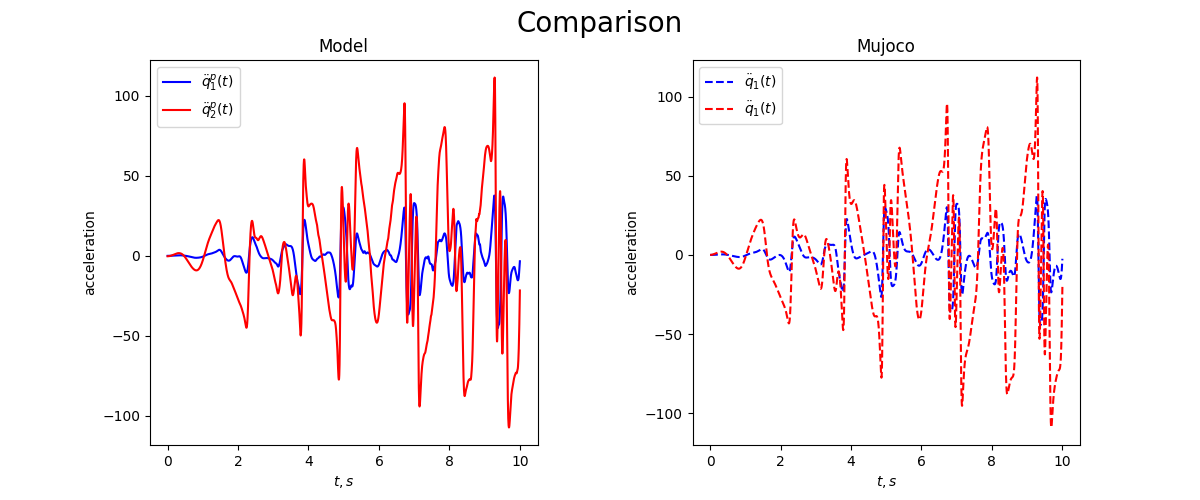

In [86]:
axes: list[plt.Axes]
figure: plt.Figure

figure, axes = plt.subplots(1, 2, figsize=(12, 5))
figure.suptitle('Comparison', fontsize=20)
figure.subplots_adjust(wspace=0.4, hspace=0.4)

axes[0].set_title('Model')
axes[0].plot(raw['time'], predicted_acc[:, 0], color='b', label='$\ddot{q}^p_1(t)$')
axes[0].plot(raw['time'], predicted_acc[:, 1], color='r', label='$\ddot{q}^p_2(t)$')
axes[0].set_xlabel('$t, s$')
axes[0].set_ylabel('acceleration')
axes[0].legend()

axes[1].set_title('Mujoco')
axes[1].plot(raw['time'], y_data[:, 0], '--', color='b', label='$\ddot{q}_1(t)$')
axes[1].plot(raw['time'], y_data[:, 1], '--', color='r', label='$\ddot{q}_1(t)$')
axes[1].set_xlabel('$t, s$')
axes[1].set_ylabel('acceleration')
axes[1].legend()

print(f'Total loss: {loss_fn(predicted_tensor, torch.tensor(y_data).to(device)).item():.3f}')